# SHL Assessment Recommendation System

### Problem Statement -
>Hiring managers often struggle to find the right assessments for the roles that they are hiring for. The current
system relies on keyword searches and filters, making the process time-consuming and inefficient.SHL Assessment Recommendation System is an intelligent recommendation system that simplifies this process. Given a natural language
query or a job description text or URL, this application returns a list of relevant SHL assessments.
Data sources that I worked with - https://www.shl.com/solutions/products/product-catalog/

## Web Scraping
> Tried Web Scraping the product catalog using selenium but couldn't scrape anything because of heavy usage of react and client-side rendering 

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

options = Options()

options.add_argument("--disable-gpu")
options.add_argument("--start-maximized")

service = Service("/opt/homebrew/bin/chromedriver")
driver = webdriver.Chrome(service=service, options=options)

driver.get("https://www.shl.com/solutions/products/product-catalog/")
time.sleep(5)

# Scroll to load all content
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

h3s = driver.find_elements(By.TAG_NAME, "h3")
print("Found", len(h3s), "h3 elements")
for h in h3s:
    print(h.text)

cards = driver.find_elements(By.CLASS_NAME, "product-card")
print(f"Found {len(cards)} product cards")

data = []
for card in cards:
    try:
        name = card.find_element(By.TAG_NAME, "h3").text
        url = card.find_element(By.TAG_NAME, "a").get_attribute("href")
        desc = card.find_element(By.TAG_NAME, "p").text
        data.append({
            "name": name,
            "url": url,
            "description": desc
        })
    except:
        continue

driver.quit()

Found 1 h3 elements

Found 0 product cards


## Using a mock dataset instead 
> Using a mock dataset to focus on  building the Recommendation System rather than focusing on web scraping

### Feaures of Mock Dataset - 
> * Assessment Name
> * URL
> * Duration (in mins)
> * Remote Testing Support (Yes/No)
> * Adaptive/IRT (Yes/No)
> * Test Type
> * Skills
> * Description

In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer,util
import torch
import matplotlib.pyplot as plt
import numpy as np

In [8]:
catalog_df = pd.read_csv("SHL_catalog.csv")
catalog_df

,Assessment Name,URL,Duration,Remote Testing Support,Adaptive/IRT,Test Type,Skills,Description
0,Java Developer Assessment #1,https://shl.com/assessment/1,40,Yes,No,Coding,Java,The 'Java Developer Assessment #1' is a Coding...
1,Full Stack Developer Test #2,https://shl.com/assessment/2,50,Yes,Yes,Coding,JavaScript,Python
2,Data Analyst Screening #3,https://shl.com/assessment/3,45,No,No,Cognitive,SQL,Python
3,Python & SQL Challenge #4,https://shl.com/assessment/4,60,Yes,Yes,Coding,Python,SQL
4,Cognitive Aptitude Test #5,https://shl.com/assessment/5,30,Yes,No,Cognitive,Problem Solving,The 'Cognitive Aptitude Test #5' is a Cognitiv...
5,Personality Insights Assessment #6,https://shl.com/assessment/6,35,Yes,No,Personality,Teamwork,Communication
6,Frontend Developer Skills Test #7,https://shl.com/assessment/7,45,No,Yes,Coding,JavaScript,Communication
7,Business Communication Evaluation #8,https://shl.com/assessment/8,25,Yes,Yes,Communication,Communication,Teamwork
8,Logical Reasoning Assessment #9,https://shl.com/assessment/9,20,Yes,No,Cognitive,Problem Solving,The 'Logical Reasoning Assessment #9' is a Cog...
9,Coding Challenge for Developers #10,https://shl.com/assessment/10,60,No,Yes,Coding,Python,Java


In [9]:
catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Assessment Name         50 non-null     object
 1   URL                     50 non-null     object
 2   Duration                50 non-null     int64 
 3   Remote Testing Support  50 non-null     object
 4   Adaptive/IRT            50 non-null     object
 5   Test Type               50 non-null     object
 6   Skills                  50 non-null     object
 7   Description             50 non-null     object
dtypes: int64(1), object(7)
memory usage: 3.3+ KB


In [9]:
def combine_row(row):
    parts = [
        str(row["Assessment Name"]),
        str(row["Duration"]),
        str(row["Remote Testing Support"]),
        str(row["Adaptive/IRT"]),
        str(row["Test Type"]),
        str(row["Skills"]),
        str(row["Description"]),
    ]
    return ' '.join(parts)

#### Combining all features into one single string to convert into word embeddings

In [10]:
catalog_df['combined'] = catalog_df.apply(combine_row,axis=1)

In [11]:
catalog_df

,Assessment Name,URL,Duration,Remote Testing Support,Adaptive/IRT,Test Type,Skills,Description,combined
0,Java Developer Assessment #1,https://shl.com/assessment/1,40,Yes,No,Coding,Java,The 'Java Developer Assessment #1' is a Coding...,Java Developer Assessment #1 40 Yes No Coding ...
1,Full Stack Developer Test #2,https://shl.com/assessment/2,50,Yes,Yes,Coding,JavaScript,Python,Full Stack Developer Test #2 50 Yes Yes Coding...
2,Data Analyst Screening #3,https://shl.com/assessment/3,45,No,No,Cognitive,SQL,Python,Data Analyst Screening #3 45 No No Cognitive S...
3,Python & SQL Challenge #4,https://shl.com/assessment/4,60,Yes,Yes,Coding,Python,SQL,Python & SQL Challenge #4 60 Yes Yes Coding Py...
4,Cognitive Aptitude Test #5,https://shl.com/assessment/5,30,Yes,No,Cognitive,Problem Solving,The 'Cognitive Aptitude Test #5' is a Cognitiv...,Cognitive Aptitude Test #5 30 Yes No Cognitive...
5,Personality Insights Assessment #6,https://shl.com/assessment/6,35,Yes,No,Personality,Teamwork,Communication,Personality Insights Assessment #6 35 Yes No P...
6,Frontend Developer Skills Test #7,https://shl.com/assessment/7,45,No,Yes,Coding,JavaScript,Communication,Frontend Developer Skills Test #7 45 No Yes Co...
7,Business Communication Evaluation #8,https://shl.com/assessment/8,25,Yes,Yes,Communication,Communication,Teamwork,Business Communication Evaluation #8 25 Yes Ye...
8,Logical Reasoning Assessment #9,https://shl.com/assessment/9,20,Yes,No,Cognitive,Problem Solving,The 'Logical Reasoning Assessment #9' is a Cog...,Logical Reasoning Assessment #9 20 Yes No Cogn...
9,Coding Challenge for Developers #10,https://shl.com/assessment/10,60,No,Yes,Coding,Python,Java,Coding Challenge for Developers #10 60 No Yes ...


## Word Embeddings
* Creating word embeddings using Sentence BERT instead of simple TF-IDF Vectorizer because it also understands context of words rather than simple word-matching. TF-IDF only focuses on frequency of words 

In [11]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [12]:
#converting each row into a vector/word embedding
corpus = catalog_df['combined'].tolist()
corpus_embeddings = model.encode(corpus,convert_to_tensor=True)

In [15]:
corpus_embeddings

tensor([[-4.1132e-02,  3.3712e-02, -1.5192e-02,  ...,  6.8478e-02,
          1.1157e-02, -3.8792e-02],
        [-8.3015e-02, -5.8202e-02,  3.8498e-02,  ...,  1.4818e-01,
          8.3665e-02, -4.9551e-02],
        [ 2.8609e-02,  1.4035e-02, -4.8932e-02,  ...,  6.8456e-03,
          6.1058e-02, -2.2603e-05],
        ...,
        [ 5.7849e-02,  1.8829e-02, -1.3150e-02,  ...,  4.9492e-02,
         -7.7539e-03, -8.2473e-02],
        [ 3.9873e-02,  2.4800e-03, -2.5676e-02,  ...,  3.8942e-02,
          8.5604e-03, -4.1729e-02],
        [-1.0276e-01, -2.3152e-02,  1.3055e-02,  ...,  1.6705e-01,
          8.0500e-02, -2.7817e-02]], device='mps:0')

## NLP Query
> Taking NLP query as an input from the user and converting it into word embedding as well then finding cosine similarities between corpus embeddings and query embedding

#### Calculating Cosine Similarities

In [16]:
def print_assessments(user_query):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embedding = model.encode(user_query, convert_to_tensor = True)
    cosine_scores = util.cos_sim(query_embedding,corpus_embeddings)[0]
    top_k = min(5,len(corpus))
    top_results = torch.topk(cosine_scores,k=top_k)
    print('Top 5 Matching Assessments:\n')
    results = []
    for score, idx in zip(top_results[0], top_results[1]):
        idx = idx.item()
        result = {
            "Assessment Name": catalog_df.iloc[idx]['Assessment Name'],
            "Skills": catalog_df.iloc[idx]['Skills'],
            "Test Type": catalog_df.iloc[idx]['Test Type'],
            "Description": catalog_df.iloc[idx]['Description'],
            "Remote Testing Support": catalog_df.iloc[idx]['Remote Testing Support'],
            "Adaptive/IRT": catalog_df.iloc[idx]['Adaptive/IRT'],
            "Duration": catalog_df.iloc[idx]['Duration'],
            "URL": catalog_df.iloc[idx]['URL'],
            "Score": round(score.item(), 4)
        }

        print(f"Assessment: {result['Assessment Name']}")
        print(f"Skills: {result['Skills']}")
        print(f"Test Type: {result['Test Type']}")
        print(f"Description: {result['Description']}")
        print(f"Remote Testing Support: {result['Remote Testing Support']}")
        print(f"Adaptive/IRT: {result['Adaptive/IRT']}")
        print(f"Duration: {result['Duration']} mins")
        print(f"URL: {result['URL']}")
        print(f"Score: {result['Score']}")
        print("-" * 50)
        
        results.append(result)
    return results

In [17]:
user_query = input("Enter your query:")
print("\n")
results = print_assessments(user_query)

Enter your query: python sql coding test




Top 5 Matching Assessments:

Assessment: Python & SQL Challenge #4
Skills: Python
Test Type: Coding
Description: SQL
Remote Testing Support: Yes
Adaptive/IRT: Yes
Duration: 60 mins
URL: https://shl.com/assessment/4
Score: 0.7926
--------------------------------------------------
Assessment: Backend Developer Challenge #29
Skills: Python
Test Type: Coding
Description: SQL
Remote Testing Support: Yes
Adaptive/IRT: Yes
Duration: 60 mins
URL: https://shl.com/assessment/29
Score: 0.7855
--------------------------------------------------
Assessment: SQL & Reporting Challenge #18
Skills: SQL
Test Type: Coding
Description: Python
Remote Testing Support: Yes
Adaptive/IRT: No
Duration: 40 mins
URL: https://shl.com/assessment/18
Score: 0.7318
--------------------------------------------------
Assessment: Data Analyst Screening #3
Skills: SQL
Test Type: Cognitive
Description: Python
Remote Testing Support: No
Adaptive/IRT: No
Duration: 45 mins
URL: https://shl.com/assessment/3
Score: 0.6229
----

In [18]:
user_query2 = input("Enter your query:")
print("\n")
result2 = print_assessments(user_query2)

Enter your query: I am hiring for an analyst and wants applications to screen using Cognitive and personality tests, what options are available within 45 mins.




Top 5 Matching Assessments:

Assessment: Cognitive Aptitude Test #5
Skills: Problem Solving
Test Type: Cognitive
Description: The 'Cognitive Aptitude Test #5' is a Cognitive test focused on Problem Solving. Duration is 30 mins. It supports remote testing: Yes and adaptive format: No.
Remote Testing Support: Yes
Adaptive/IRT: No
Duration: 30 mins
URL: https://shl.com/assessment/5
Score: 0.5845
--------------------------------------------------
Assessment: Critical Thinking & Aptitude Test #30
Skills: Problem Solving
Test Type: Cognitive
Description: The 'Critical Thinking & Aptitude Test #30' is a Cognitive test focused on Problem Solving. Duration is 40 mins. It supports remote testing: Yes and adaptive format: No.
Remote Testing Support: Yes
Adaptive/IRT: No
Duration: 40 mins
URL: https://shl.com/assessment/30
Score: 0.5815
--------------------------------------------------
Assessment: Developer Personality Assessment #25
Skills: Personality
Test Type: Personality
Description: The '

## Metrics to compute Accuracy

> * Mean recall @K - This metric measures how many of the relevant assessments were retrieved in the top K
recommendations, averaged across all test queries.
> * Mean Average Precision @K (MAP@K) - MAP@K evaluates both the relevance and ranking order of retrieved assessments by calculating
Precision@k at each relevant result and averaging it over all queries.

In [40]:
def compute_metrics(benchmark_queries,k=5):
    recall_scores = []
    average_precisions = []

    for entry in benchmark_queries:
        query = entry["query"]
        relevant_items = entry["relevant"]

        results = find_assessments(query)
        topk = [res["Assessment Name"] for res in results[:k]]

        #recall@k
        count = 0
        for item in topk:
            if item in relevant_items:
                count+=1
        recall_score = count/len(relevant_items)
        recall_scores.append(recall_score)

        #map@k
        ap = 0.0
        relevant_count = 0
        for i,res in enumerate(topk):
            if res in relevant_items:
                relevant_count+=1
                precision_at_k = relevant_count/(i+1)
                ap += precision_at_k
        ap = ap/min(k,len(relevant_items))
        average_precisions.append(ap)
        
    recall = sum(recall_scores)/len(recall_scores)
    map_ = sum(average_precisions)/len(average_precisions)
    
    print(f"Recall@{k}: {recall:.4f}")
    print(f"MAP@{k}: {map_:.4f}")

In [13]:
def find_assessments(user_query,k=5):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embedding = model.encode(user_query, convert_to_tensor = True)
    cosine_scores = util.cos_sim(query_embedding,corpus_embeddings)[0]
    top_k = min(k,len(corpus))
    top_results = torch.topk(cosine_scores,k=top_k)
    results = []
    for score, idx in zip(top_results[0], top_results[1]):
        idx = idx.item()
        result = {
            "Assessment Name": catalog_df.iloc[idx]['Assessment Name'],
            "Skills": catalog_df.iloc[idx]['Skills'],
            "Test Type": catalog_df.iloc[idx]['Test Type'],
            "Description": catalog_df.iloc[idx]['Description'],
            "Remote Testing Support": catalog_df.iloc[idx]['Remote Testing Support'],
            "Adaptive/IRT": catalog_df.iloc[idx]['Adaptive/IRT'],
            "Duration": catalog_df.iloc[idx]['Duration'],
            "URL": catalog_df.iloc[idx]['URL'],
            "Score": round(score.item(), 4)
        }
        results.append(result)
    return results

In [39]:
benchmark_queries = [
    {
        "query": "I am hiring for Java developers who can also collaborate effectively with my business teams. Looking for an assessment that can be completed in 40 minutes.",
        "relevant": ["Java Developer Assessment #1","Quick Java Screening #27","Java Coding Drill #47"]
    },
    {
        "query": "Suggest an assessment for a fresher data analyst that includes Python and SQL skills in under 50 minutes.",
        "relevant": ["Data Analyst Screening #3","SQL & Reporting Challenge #18","Cross-functional Assessment #41"]
    },
    {
        "query": "Looking for remote-enabled JavaScript technical assessment. Needs to be adaptive.",
        "relevant": ["JavaScript Screening Test #11"]
    },
    {
        "query": "Want to assess communication and teamwork skills in under 30 minutes.",
        "relevant": ["Communication Skills Test #19","Business Communication Evaluation #8","Communication & Team Fit #24","Interpersonal Skills Assessment #43"]
    },
]

In [42]:
compute_metrics(benchmark_queries,k=5)

Recall@5: 0.8542
MAP@5: 0.7181


## When we keep K as 5 and find Recall@5 and MAP@5 the results are :-
> Recall = 0.8542 and MAP = 0.7181. These results are when we use ONLY NLP TECHNIQUES

## As we increase the value of K, how does Recall and Map get affected?

In [23]:
def compute_metrics_at_ks(benchmark_queries, ks=[1, 3, 5, 10]):
    recalls = []
    maps = []

    for k in ks:
        recall_scores = []
        average_precisions = []

        for entry in benchmark_queries:
            relevant_items = entry["relevant"]
            results = find_assessments(entry["query"])
            topk = [res["Assessment Name"] for res in results[:k]]

            # Recall@K
            matched = sum(1 for item in topk if item in relevant_items)
            recall = matched / len(relevant_items)
            recall_scores.append(recall)

            # MAP@K
            ap = 0.0
            relevant_count = 0
            for i, res in enumerate(topk):
                if res in relevant_items:
                    relevant_count += 1
                    ap += relevant_count / (i + 1)
            ap = ap / min(k, len(relevant_items))
            average_precisions.append(ap)

        recalls.append(sum(recall_scores) / len(recall_scores))
        maps.append(sum(average_precisions) / len(average_precisions))

    return ks, recalls, maps

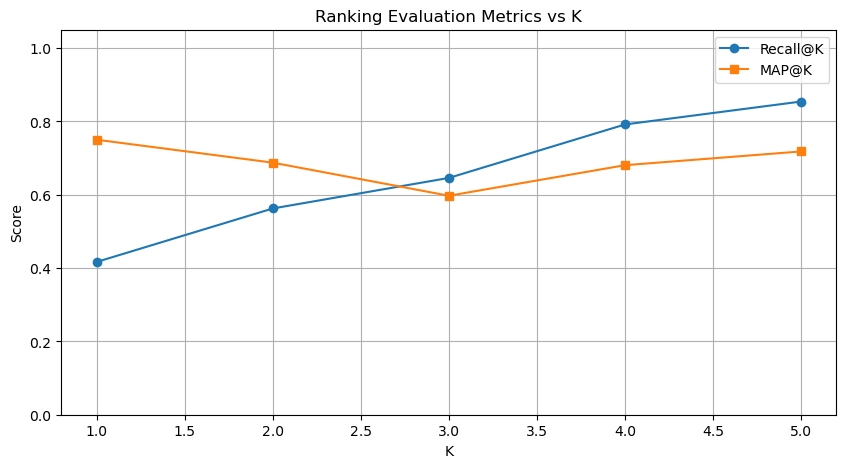

In [24]:
ks, recalls, maps = compute_metrics_at_ks(benchmark_queries, ks=[1, 2, 3, 4, 5])

plt.figure(figsize=(10, 5))
plt.plot(ks, recalls, label="Recall@K", marker='o')
plt.plot(ks, maps, label="MAP@K", marker='s')
plt.title("Ranking Evaluation Metrics vs K")
plt.xlabel("K")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

## Extracting Job Description text from URL

In [14]:
import requests
from bs4 import BeautifulSoup

In [15]:
def extract_text_from_url(url):
    try:
        response = requests.get(url,headers={'User-Agent':"Mozilla/5.0"})
        soup = BeautifulSoup(response.text,'html.parser')
        return ' '.join(soup.get_text().split())
    except Exception as e:
        return f"Error:{e}"

In [16]:
extracted_text = extract_text_from_url("https://www.linkedin.com/jobs/view/research-engineer-ai-at-shl-4194768899/?originalSubdomain=in")
print(extracted_text)

SHL hiring Research Engineer, AI in Gurgaon, Haryana, India | LinkedIn Skip to main content LinkedIn Research Engineer, AI in Mumbai Expand search This button displays the currently selected search type. When expanded it provides a list of search options that will switch the search inputs to match the current selection. Jobs People Learning Clear text Clear text Clear text Clear text Clear text Join now Sign in Research Engineer, AI SHL Gurgaon, Haryana, India Apply Join or sign in to find your next job Join to apply for the Research Engineer, AI role at SHL Not you? Remove photo First name Last name Email Password (6+ characters) By clicking Agree & Join, you agree to the LinkedIn User Agreement, Privacy Policy and Cookie Policy. Continue Agree & Join or You may also apply directly on company website. Security verification Already on LinkedIn? Sign in Research Engineer, AI SHL Gurgaon, Haryana, India 1 week ago Over 200 applicants See who SHL has hired for this role Apply Join or sign

## Leveraging LLM for improving the Recommendation System (Gemini 1.5 Pro)

In [10]:
pip install google-generativeai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import google.generativeai as genai

#genai.configure(api_key=GEMINI_API_KEY)

In [33]:
model = genai.GenerativeModel("gemini-1.5-pro")

In [19]:
import re

def extract_url_from_text(text):
    match = re.search(r'(https?://[^\s,]+)', text)
    if match:
        return match.group(1)
    return None

### Extracting Relevant Features using LLM

In [23]:
def extract_features_with_llm(user_query):
    prompt = f"""
You are an intelligent assistant helping to recommend SHL assessments.

The input below may be:
1. A natural language query describing assessment needs (e.g., "Need a Python test under 60 minutes").
2. A job description (JD) pasted directly.
3. A job description URL (already converted into text outside this function).
4. A combination of user query + JD.

Your task is to extract and summarize key hiring features from the input. Look for and include the following **if available**:

- Job Title  
- Duration of Test  
- Remote Testing Support (Yes/No)  
- Adaptive/IRT Format (Yes/No)  
- Test Type  
- Skills Required  
- Any other relevant hiring context

Format your response as a **single line** like this:

`<Job Title> <Duration> <Remote Support> <Adaptive> <Test Type> <Skills> <Other Info>`

Skip any fields not mentioned — do not include placeholders or "N/A".

---
Input:
{user_query}

Only return the final, clean sentence — no explanations.
"""

    response = model.generate_content(prompt)
    return response.text.strip()

In [33]:
query = "Here is a JD text:https://www.linkedin.com/jobs/view/research-engineer-ai-at-shl-4194768899/?originalSubdomain=in, can you recommend some assessment that can help me screen applications. Time limit is less than 30 minutes."

url = extract_url_from_text(query)
print("Extracted URL -",url)
print("\n")
if url:
    extracted_text = extract_text_from_url(url)
    query += " "+ extracted_text
    user_query = extract_features_with_llm(query)
    print("LLM extracted query - ",user_query)
    print("\n")
    print_assessments(user_query)
    
else:
    print_assessments(query)

Extracted URL - https://www.linkedin.com/jobs/view/research-engineer-ai-at-shl-4194768899/?originalSubdomain=in


LLM extracted query -  Research Engineer 30 minutes  AI/ML, NLP, speech processing, computer vision, Python, TensorFlow, PyTorch, OpenAI APIs, deep learning, statistical modeling, Generative AI, LLM, RAG


Top 5 Matching Assessments:

Assessment: Entry-Level Developer Screening #23
Skills: Python
Test Type: Coding
Description: JavaScript
Remote Testing Support: Yes
Adaptive/IRT: No
Duration: 30 mins
URL: https://shl.com/assessment/23
Score: 0.363
--------------------------------------------------
Assessment: Junior Developer Aptitude #34
Skills: Python
Test Type: Coding
Description: JavaScript
Remote Testing Support: Yes
Adaptive/IRT: No
Duration: 35 mins
URL: https://shl.com/assessment/34
Score: 0.333
--------------------------------------------------
Assessment: Mid-Level Developer Evaluation #20
Skills: Python
Test Type: Coding
Description: JavaScript
Remote Testing Supp

### Handling all 3 input cases using LLM
> * NLP Query
> * URL
> * JD Text

In [34]:
def query_handling_using_LLM(query):
    url = extract_url_from_text(query)
    if url:
        extracted_text = extract_text_from_url(url)
        query += " " + extracted_text
        user_query = extract_features_with_llm(query)
        print("LLM extracted query - ",user_query)
        print("\n")
        print_assessments(user_query)
    else:
        user_query = extract_features_with_llm(query)
        print_assessments(user_query)

In [37]:
user_query = input("Enter your query:")
query_handling_using_LLM(user_query)

Enter your query: Looking to hire mid-level professionals who are proficient in Python, SQL and Java Script. Need an assessment package that can test all skills with max duration of 60 minutes.


Top 5 Matching Assessments:

Assessment: Backend Developer Challenge #29
Skills: Python
Test Type: Coding
Description: SQL
Remote Testing Support: Yes
Adaptive/IRT: Yes
Duration: 60 mins
URL: https://shl.com/assessment/29
Score: 0.6574
--------------------------------------------------
Assessment: SQL & Reporting Challenge #18
Skills: SQL
Test Type: Coding
Description: Python
Remote Testing Support: Yes
Adaptive/IRT: No
Duration: 40 mins
URL: https://shl.com/assessment/18
Score: 0.5945
--------------------------------------------------
Assessment: Python & SQL Challenge #4
Skills: Python
Test Type: Coding
Description: SQL
Remote Testing Support: Yes
Adaptive/IRT: Yes
Duration: 60 mins
URL: https://shl.com/assessment/4
Score: 0.5937
--------------------------------------------------
Assessment: Python Backend Developer Assessment #17
Skills: Python
Test Type: Coding
Description: Problem Solving
Remote Testing Support: Yes
Adaptive/IRT: Yes
Duration: 60 mins
URL: https://shl.com/assessme

In [53]:
user_query = input("Enter your query:")
query_handling_using_LLM(user_query)

Enter your query: I am hiring for Java developers who can also collaborate effectively with my business teams. Looking for an assessment(s) that can be completed in 40 minutes.


Top 5 Matching Assessments:

Assessment: Java Developer Assessment #1
Skills: Java
Test Type: Coding
Description: The 'Java Developer Assessment #1' is a Coding test focused on Java. Duration is 40 mins. It supports remote testing: Yes and adaptive format: No.
Remote Testing Support: Yes
Adaptive/IRT: No
Duration: 40 mins
URL: https://shl.com/assessment/1
Score: 0.6367
--------------------------------------------------
Assessment: Java Coding Drill #47
Skills: Java
Test Type: Coding
Description: The 'Java Coding Drill #47' is a Coding test focused on Java. Duration is 40 mins. It supports remote testing: Yes and adaptive format: No.
Remote Testing Support: Yes
Adaptive/IRT: No
Duration: 40 mins
URL: https://shl.com/assessment/47
Score: 0.5564
--------------------------------------------------
Assessment: Quick Java Screening #27
Skills: Java
Test Type: Coding
Description: The 'Quick Java Screening #27' is a Coding test focused on Java. Duration is 30 mins. It supports remote testing: Y

## Upgrading our Recommendation System using LLMs
### Now our recommendation system got better after using LLM as it -
* Extracts relevant features from NLP Query, JD Text, JD URL + NLP Query or just JD URL
* Adds them in a single string and it is converted into word embeddings using Sentence Transformer
* Cosine Similarity is calculated and top 10 relevant assessments are recommended
* Those assessments are then further cross checked by LLM after understanding the meaning of NLP query and only those which are relevant to the recruiter will be shown otherwise a message is shown as well.
* Due to only 50 entries in the Mock Dataset a few queries return no relevant assessments found but after getting full access to SHL website it can be unbeatable.

In [36]:
def filter_relevant_assessments_with_llm(user_query, top_results):
    prompt = f"""
You are helping to refine assessment recommendations based on user needs.

A user has entered the following query:
"{user_query}"

You are given 10 or less assessments retrieved using semantic similarity. 
Your task is to go through each assessment and determine if it truly matches the user’s intent, based on the following:
- Duration match (e.g., if the user wants "< 40 mins", exclude longer ones)
- Skills match (e.g., user wants "Python" but test is on "Excel", reject it)
- Remote support, Adaptive format, Test type, or any clearly stated requirement
- Ignore irrelevant matches, even if score is high

Return only the assessments that are **highly relevant** to the query. 
Use your understanding of language and hiring to filter smartly. But you have to return something atleast 1 assessment.
You have to return minimum 1 assessment and maximum 10(only relevant ones). You cannot return empty json.

Respond in clean JSON format:
[
  {{
    "Assessment Name": "...",
    "Skills": "...",
    "Test Type": "...",
    "Description": "...",
    "Remote Testing Support": "...",
    "Adaptive/IRT": "...",
    "Duration": "... mins",
    "URL": "...",
    "Score": ...
  }},
  ...
]

---
Assessments:
{top_results}
"""

    response = model.generate_content(prompt)
    return response.text.strip()

In [21]:
import json

def convert_numpy(obj):
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    else:
        raise TypeError(f"Object of type {type(obj)} is not JSON serializable")
        
def query_handling_using_LLM_updated(query):
    url = extract_url_from_text(query)

    if url:
        extracted_text = extract_text_from_url(url)
        query += " " + extracted_text

    # Step 1: Use LLM to extract structured query
    user_query = extract_features_with_llm(query)
    print("LLM extracted query -", user_query)
    print("\n")

    # Step 2: Get top 10 similar assessments unless k is given
    top_results = find_assessments(user_query,k=10)

    # Step 3: Convert list of dicts to JSON string for Gemini
    top_json = json.dumps(top_results, indent=2, default=convert_numpy)

    # Step 4: Get LLM-filtered relevant assessments
    filtered_output = filter_relevant_assessments_with_llm(user_query, top_json)

    # Step 5: Parse LLM response safely
    try:
        filtered_results = json.loads(filtered_output)
    except json.JSONDecodeError:
        print("Gemini returned invalid JSON. Raw output below:\n")
        print(filtered_output)
        return

    # Step 6: Show results
    if not filtered_results:
        print("No recommendations found based on your query.")
    else:
        for result in filtered_results:
            print(f"Assessment: {result['Assessment Name']}")
            print(f"Skills: {result['Skills']}")
            print(f"Test Type: {result['Test Type']}")
            print(f"Description: {result['Description']}")
            print(f"Remote Testing Support: {result['Remote Testing Support']}")
            print(f"Adaptive/IRT: {result['Adaptive/IRT']}")
            print(f"Duration: {result['Duration']} mins")
            print(f"URL: {result['URL']}")
            print(f"Score: {result['Score']}")
            print("-" * 50)

In [24]:
user_query = input("Enter your query: ")
query_handling_using_LLM_updated(user_query)

Enter your query:  I am hiring for Java developers who can also collaborate effectively with my business teams. Looking for an assessment(s) that can be completed in 40 minutes.


LLM extracted query - Java Developer 40 minutes  Adaptive Java Collaboration with business teams


Gemini returned invalid JSON. Raw output below:

```json
[
  {
    "Assessment Name": "Java Developer Assessment #1",
    "Skills": "Java",
    "Test Type": "Coding",
    "Description": "The 'Java Developer Assessment #1' is a Coding test focused on Java. Duration is 40 mins. It supports remote testing: Yes and adaptive format: No.",
    "Remote Testing Support": "Yes",
    "Adaptive/IRT": "No",
    "Duration": 40,
    "URL": "https://shl.com/assessment/1",
    "Score": 0.5765
  },
  {
    "Assessment Name": "Java Coding Drill #47",
    "Skills": "Java",
    "Test Type": "Coding",
    "Description": "The 'Java Coding Drill #47' is a Coding test focused on Java. Duration is 40 mins. It supports remote testing: Yes and adaptive format: No.",
    "Remote Testing Support": "Yes",
    "Adaptive/IRT": "No",
    "Duration": 40,
    "URL": "https://shl.com/assessment/47",
    "Score": 0.5049
  },

In [38]:
user_query = input("Enter your query: ")
query_handling_using_LLM_updated(user_query)

Enter your query:  I am hiring for an analyst and wants applications to screen using Cognitive and personality tests, what options are available within 45 mins.


LLM extracted query - Analyst 45 mins  Cognitive, Personality


Gemini returned invalid JSON. Raw output below:

```json
[
  {
    "Assessment Name": "Entry-level Analyst Test #42",
    "Skills": "Problem Solving",
    "Test Type": "Cognitive",
    "Description": "SQL",
    "Remote Testing Support": "Yes",
    "Adaptive/IRT": "No",
    "Duration": 30,
    "URL": "https://shl.com/assessment/42",
    "Score": 0.5902
  },
  {
    "Assessment Name": "Personality Insights Assessment #6",
    "Skills": "Teamwork",
    "Test Type": "Personality",
    "Description": "Communication",
    "Remote Testing Support": "Yes",
    "Adaptive/IRT": "No",
    "Duration": 35,
    "URL": "https://shl.com/assessment/6",
    "Score": 0.5512
  },
    {
    "Assessment Name": "Personality Profiler #40",
    "Skills": "Personality",
    "Test Type": "Personality",
    "Description": "The 'Personality Profiler #40' is a Personality test focused on Personality. Duration is 30 mins. It supports remote testing: Yes

## Handling Edge Cases with LLM as well
> Here accoridng to the mock dataset no actual assessment matched the query but still we have to return minimum 1 assessment so the assessments with high cosine similarity scores are returned.

In [39]:
user_query = input("Enter your query: ")
query_handling_using_LLM_updated(user_query)

Enter your query:  Here is a JD text https://www.linkedin.com/jobs/view/research-engineer-ai-at-shl-4194768899/?originalSubdomain=in , can you recommend some assessment that can help me screen applications. Time limit is less than 30 minutes.


LLM extracted query - Research Engineer 30 minutes  Adaptive Python NLP, Computer Vision, Machine Learning, Deep Learning, Generative AI (LLMs & RAG)


Gemini returned invalid JSON. Raw output below:

```json
[
  {
    "Assessment Name": "Entry-Level Developer Screening #23",
    "Skills": "Python",
    "Test Type": "Coding",
    "Description": "JavaScript",
    "Remote Testing Support": "Yes",
    "Adaptive/IRT": "No",
    "Duration": 30,
    "URL": "https://shl.com/assessment/23",
    "Score": 0.4254
  }
]
```


## Comparing the results using simple NLP vs NLP+LLM approach

In [17]:
def k_relevant_assessments_with_llm(user_query, top_results,k):
    prompt = f"""
You are helping to refine assessment recommendations based on user needs.

A user has entered the following query:
"{user_query}"

You are given 10 or less assessments retrieved using semantic similarity. 
Your task is to go through each assessment and determine if it truly matches the user’s intent, based on the following:
- Duration match (e.g., if the user wants "< 40 mins", exclude longer ones)
- Skills match (e.g., user wants "Python" but test is on "Excel", reject it)
- Remote support, Adaptive format, Test type, or any clearly stated requirement
- Ignore irrelevant matches, even if score is high

Return only {k} number of assessments that are **highly relevant** to the query. 
Use your understanding of language and hiring to filter smartly.

Respond in clean JSON format:
[
  {{
    "Assessment Name": "...",
    "Skills": "...",
    "Test Type": "...",
    "Description": "...",
    "Remote Testing Support": "...",
    "Adaptive/IRT": "...",
    "Duration": "... mins",
    "URL": "...",
    "Score": ...
  }},
  ...
]

---
Assessments:
{top_results}
"""

    response = model.generate_content(prompt)
    return response.text.strip()

In [41]:
import time  # Make sure this is imported

def compute_metrics_llm(benchmark_queries, k=5, delay=60):
    recall_scores = []
    average_precisions = []
    valid_queries = 0

    for entry in benchmark_queries:
        query = entry["query"]
        relevant_items = entry["relevant"]

        url = extract_url_from_text(query)
        if url:
            extracted_text = extract_text_from_url(url)
            query += " " + extracted_text
            
        user_query = extract_features_with_llm(query)
        top_results = find_assessments(user_query, k=10)
        top_json = json.dumps(top_results, indent=2, default=convert_numpy)

        filtered_output = k_relevant_assessments_with_llm(user_query, top_json, k=k)

        try:
            if filtered_output.startswith("```json"):
                filtered_output = re.sub(r"^```json\s*|\s*```$", "", filtered_output.strip(), flags=re.DOTALL)

            filtered_results = json.loads(filtered_output)
            topk = [res["Assessment Name"] for res in filtered_results if "Assessment Name" in res]

            if not topk:
                raise ValueError("No 'Assessment Name' found in results.")
        except Exception as e:
            print(f"[Warning] Skipping query due to error: {e}\nRaw output: {filtered_output}")
            time.sleep(delay)  # Delay even if there's an error
            continue

        valid_queries += 1

        # Recall@k
        relevant_count = sum(1 for item in topk if item in relevant_items)
        recall = relevant_count / len(relevant_items)
        recall_scores.append(recall)

        # MAP@k
        ap = 0.0
        matched = 0
        for i, item in enumerate(topk):
            if item in relevant_items:
                matched += 1
                precision_at_k = matched / (i + 1)
                ap += precision_at_k
        ap /= min(k, len(relevant_items))
        average_precisions.append(ap)

        time.sleep(delay)  

    if valid_queries == 0:
        print("No valid queries were processed. Please check the LLM outputs or data format.")
        return

    mean_recall = sum(recall_scores) / valid_queries
    mean_ap = sum(average_precisions) / valid_queries

    print(f"LLM Recall@{k}: {mean_recall:.4f}")
    print(f"LLM MAP@{k}: {mean_ap:.4f}")

In [42]:
benchmark_queries = [
    {
        "query": "I am hiring for Java developers who can also collaborate effectively with my business teams. Looking for an assessment that can be completed in 40 minutes.",
        "relevant": ["Java Developer Assessment #1","Quick Java Screening #27","Java Coding Drill #47"]
    },
    {
        "query": "Suggest an assessment for a fresher data analyst that includes Python and SQL skills in under 50 minutes.",
        "relevant": ["Data Analyst Screening #3","SQL & Reporting Challenge #18","Cross-functional Assessment #41"]
    },
    {
        "query": "Looking for remote-enabled JavaScript technical assessment. Needs to be adaptive.",
        "relevant": ["JavaScript Screening Test #11"]
    },
    {
        "query": "Want to assess communication and teamwork skills in under 30 minutes.",
        "relevant": ["Communication Skills Test #19","Business Communication Evaluation #8","Communication & Team Fit #24","Interpersonal Skills Assessment #43"]
    },
]
compute_metrics_llm(benchmark_queries, k=5)

[Warning] Skipping query due to error: Extra data: line 58 column 1 (char 1896)
Raw output: [
  {
    "Assessment Name": "Java Developer Assessment #1",
    "Skills": "Java",
    "Test Type": "Coding",
    "Description": "The 'Java Developer Assessment #1' is a Coding test focused on Java. Duration is 40 mins. It supports remote testing: Yes and adaptive format: No.",
    "Remote Testing Support": "Yes",
    "Adaptive/IRT": "No",
    "Duration": 40,
    "URL": "https://shl.com/assessment/1",
    "Score": 0.5784
  },
  {
    "Assessment Name": "Java Coding Drill #47",
    "Skills": "Java",
    "Test Type": "Coding",
    "Description": "The 'Java Coding Drill #47' is a Coding test focused on Java. Duration is 40 mins. It supports remote testing: Yes and adaptive format: No.",
    "Remote Testing Support": "Yes",
    "Adaptive/IRT": "No",
    "Duration": 40,
    "URL": "https://shl.com/assessment/47",
    "Score": 0.5119
  },
  {
    "Assessment Name": "Quick Java Screening #27",
    "Ski

### Upgraded Model using LLMs have a perfect accuracy as Recall@5 = 1.0 and Map@5 = 1.0

## Difference between using NLP approach and Hybrid approach(NLP+LLM)
> * NLP Model - Recall@5 = 0.8542 and MAP@5 = 0.7181
> * NLP + LLM Model - Recall@5 = 1.0 and MAP@5 = 1.0